<!--Header-->
<div style="background-color: #fff; color: black">
<div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
<div style="width: 60%;">
<h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
<p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
</div>
<div style="width: 40%; text-align: right">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
</div>
</div>
<h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
<div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
<div style="padding: 20px">
<h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
<h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
<h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
<h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
<h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
</div>
</div>

# Fase 2
#### Tercera Parte

## Explicabilidad del modelo


Tras el entrenamiento y evaluación de los algoritmos de clasificación binaria y la selección del modelo óptimo, el siguiente paso fundamental es comprender cómo este modelo toma sus decisiones. La explicabilidad permite desentrañar el comportamiento interno del clasificador y evaluar cómo sus predicciones se alinean con las características del caso.

Buscamos asegurarnos de que el modelo llega a sus predicciones utilizando las características del dominio de forma clínicamente coherente, y no a través de atajos que simplemente optimicen las métricas. Este aspecto es fundamental, ya que la capacidad de generalización del modelo frente a nuevos casos dependerá, en gran medida, de su correcto funcionamiento interno. Además, este funcionamiento determinará su utilidad funcional real más allá del acierto estadístico, lo que resulta clave para su aplicación en un entorno clínico en el que la interpretabilidad y la confianza son tan importantes como la precisión.

Desde el punto de vista de la regulación de la Unión Europea (AI Act)[1], esta fase adquiere especial relevancia, ya que uno de los principios fundamentales para los sistemas de inteligencia artificial de alto riesgo —como los aplicados en el ámbito sanitario— es la explicabilidad y trazabilidad de las decisiones automatizadas. El artículo 13 del AI Act establece que los sistemas deben proporcionar información comprensible sobre su lógica de funcionamiento, así como sobre los factores que influyen en el resultado. En este contexto, dotar al modelo de capacidad explicativa no solo mejora su aceptación por parte de los profesionales clínicos, sino que también contribuye al cumplimiento normativo y refuerza la confianza de los pacientes en su uso.

Este cuaderno corresponde a la tercera parte de la fase 2 del plan de trabajo del TFG. Se aborda la explicabilidad del modelo seleccionado en el cuaderno de clasificación binaria [2] y continúa la fase de modelado establecida por la metodología CRISP-DM.

### Objetivos

El objetivo de esta sección es proporcionar interpretaciones locales y globales del mejor modelo seleccionado mediante técnicas de interpretabilidad post-hoc. Para ello, se utiliza LIME (Local Interpretable Model-Agnostic Explanations), que permite analizar la contribución de cada variable a la predicción individual de un paciente. Este análisis es especialmente útil para los profesionales sanitarios, ya que aporta una justificación comprensible sobre por qué se considera que un paciente presenta una calidad de vida mejorable.

Además, se realiza un estudio con gráficos PDP (Partial Dependence Plot) y ICE (Individual Conditional Expectation) para observar cómo las variables más relevantes afectan a las predicciones del modelo a nivel global y local. Estas herramientas ayudan a validar si las relaciones aprendidas por el modelo tienen sentido clínico y si existen umbrales críticos o no linealidades que deban tenerse en cuenta.

En conjunto, esta fase proporciona una capa de transparencia y confianza adicional, crucial para la posterior integración del modelo en un sistema de soporte a la decisión clínica.

### Estrategia

Para abordar la explicabilidad del modelo seleccionado, se ha seguido una estrategia estructurada en diferentes niveles de análisis que permiten interpretar el comportamiento del clasificador desde perspectivas globales y locales:
	1.	Importancia de características
	•	Feature Importance nativa del modelo Random Forest, que ofrece una primera visión basada en la ganancia de información acumulada durante el entrenamiento.
	•	Feature Importance por permutación, que permite evaluar de forma agnóstica el impacto de cada variable sobre el rendimiento predictivo al modificar su distribución.
	2.	Gráficos de dependencia parcial (PDP) y efectos individuales (ICE): se trata de representaciones que permiten analizar el efecto medio y específico que tiene cada variable sobre la probabilidad predicha de la clase positiva, ayudando a detectar posibles relaciones no lineales o interacciones.
	3.	Explicaciones locales con SHAP: se aplican descomposiciones SHAP (SHapley Additive exPlanations) para analizar la contribución de cada característica en predicciones individuales, destacando tanto valores esperados como desviaciones puntuales y permitiendo contrastar resultados en observaciones críticas.
	4.	Selección de casos representativos: se identifican y analizan observaciones correctamente clasificadas, falsos negativos y falsos positivos. Estas se utilizan como ejemplos para la interpretación con SHAP, permitiendo comprobar si el modelo fundamenta sus decisiones en variables clínicamente razonables.

### Índice

1. Importancia de variables por permutación
2. Dependencia parcial
3. Expectación condicional individual
4. LIME: Explicaciones localmente interpretables independientes del modelo
5. DiCE: Explicaciones contrafactuales diversas
6. SHAP: Explicaciones aditivas basadas en valores de Shapley
7. Conclusiones

### Importaciones y configuraciones

In [1]:
# Importaciones de librerías básicas
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Importaciones de Scikit-learn 
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.inspection import permutation_importance

# Librerías XAI
import shap
from lime import lime_tabular
import dice_ml as dice

# Funciones auxiliares
import aux_functions as afn

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', size=10)
plt.rcParams["legend.frameon"] = False
sns.set_theme(
    style="white",
    palette="viridis",
    rc={
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)
sns.set_style("white", {"axes.grid": False})

### Carga de los datos

Cargamos los conjuntos de datos que se han generado en la fase de modelado para la clasificación binaria. 

In [3]:
X_train = pd.read_csv('./data/QLQ_C30_C23_X_train.csv')
X_test = pd.read_csv('./data/QLQ_C30_C23_X_test.csv')
y_train = pd.read_csv('./data/QLQ_C30_C23_y_train.csv').squeeze()
y_test = pd.read_csv('./data/QLQ_C30_C23_y_test.csv').squeeze()

### Carga del modelo seleccionado

Se carga el modelo final entrenado durante la fase de clasificación binaria. El modelo ha sido previamente almacenado en un archivo serializado (best_bundle.pkl), que incluye tanto el clasificador como el umbral de decisión óptimo identificado durante el ajuste final.

Luego, se utiliza la clase FixedThresholdClassifier para crear una instancia del modelo que aplica el umbral personalizado directamente sobre las probabilidades predichas (predict_proba). De esta forma, se garantiza que todas las explicaciones posteriores reflejen fielmente el comportamiento real del clasificador tal y como fue evaluado, sin depender del umbral por defecto.

In [4]:
bundle = joblib.load('./models/best_bundle.pkl')
model = bundle['model']
threshold = bundle['threshold']
model_thresholded = FixedThresholdClassifier(model, threshold=threshold, response_method="predict_proba").fit(X_train, y_train)

## 1. Importancia de variables por permutación

La importancia de variables por permutación evalúa de forma agnóstica el impacto individual de cada característica sobre el rendimiento del modelo. Consiste en medir la caída en la métrica de evaluación (en este caso, f1-score) al alterar aleatoriamente los valores de cada variable, rompiendo así su relación con la variable objetivo. Cuanto mayor es la pérdida de rendimiento, mayor es la relevancia de la variable.

En este análisis se aplica la técnica sobre los conjuntos de entrenamiento y prueba, utilizando el modelo final de Random Forest. Los resultados se representan mediante diagramas de caja comparativos, lo que permite observar la estabilidad de la importancia entre ambos conjuntos y detectar posibles variables que influyen de forma inconsistente. Esta comparación es clave para identificar características robustas y evitar sobreinterpretaciones ligadas exclusivamente al conjunto de entrenamiento.

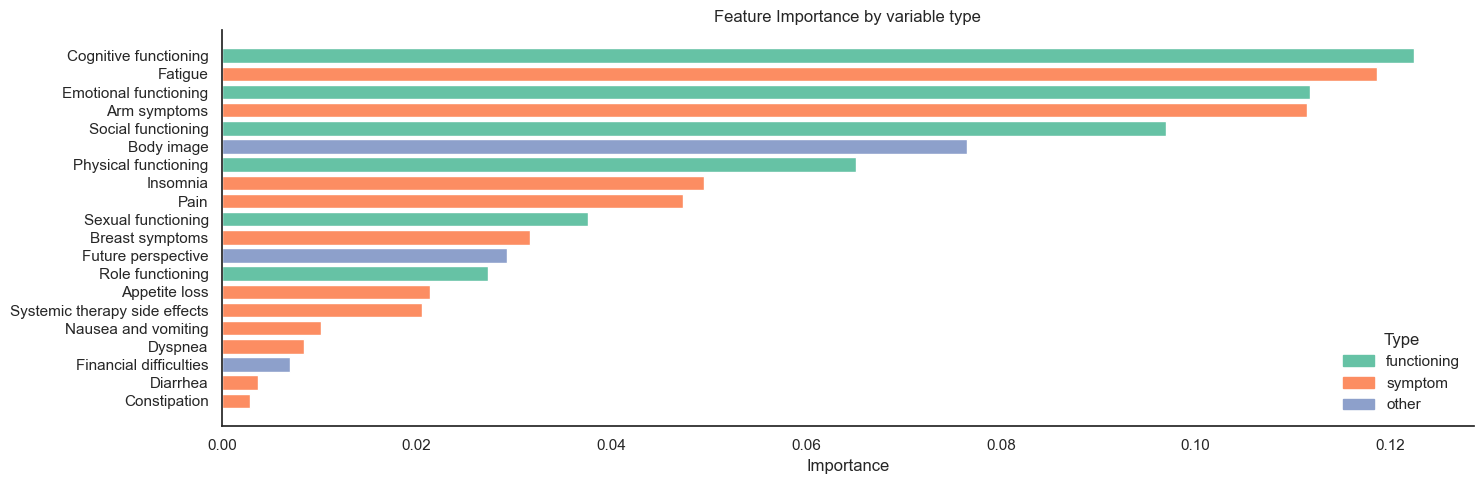

In [6]:
# Visualizamos la importancia nativa de las variables según el modelo
model_sorted_features_imp = sorted(
    zip(X_test.columns, model.feature_importances_),
    key=lambda x: x[1]
)
model_imp_features, model_imp_sorted = zip(*model_sorted_features_imp)
afn.viz_feature_importance(model_sorted_features_imp)

La gráfica muestra la importancia de las variables según su tipo clínico (funcionales, síntomas u otras), calculada a partir del modelo. Se observa que las características relacionadas con el funcionamiento (functioning) ocupan sistemáticamente los primeros puestos, destacando especialmente Cognitive functioning y Emotional functioning. Entre las variables sintomáticas, Fatigue y Arm symptoms aparecen con gran peso, lo que indica que el modelo también considera aspectos relacionados con el malestar físico.

Otras variables sintomáticas como Pain, Insomnia o Appetite loss muestran una importancia intermedia, lo que sugiere que, aunque el modelo se apoya principalmente en el estado funcional general, los síntomas juegan también un papel relevante en la predicción.

Por último, las variables clasificadas como other, con la excepción destacada de Body image, tienden a ocupar posiciones más bajas. Este patrón indica que su peso predictivo es más limitado en comparación con los dominios clínicos principales, aunque su presencia en el modelo sigue aportando información complementaria.

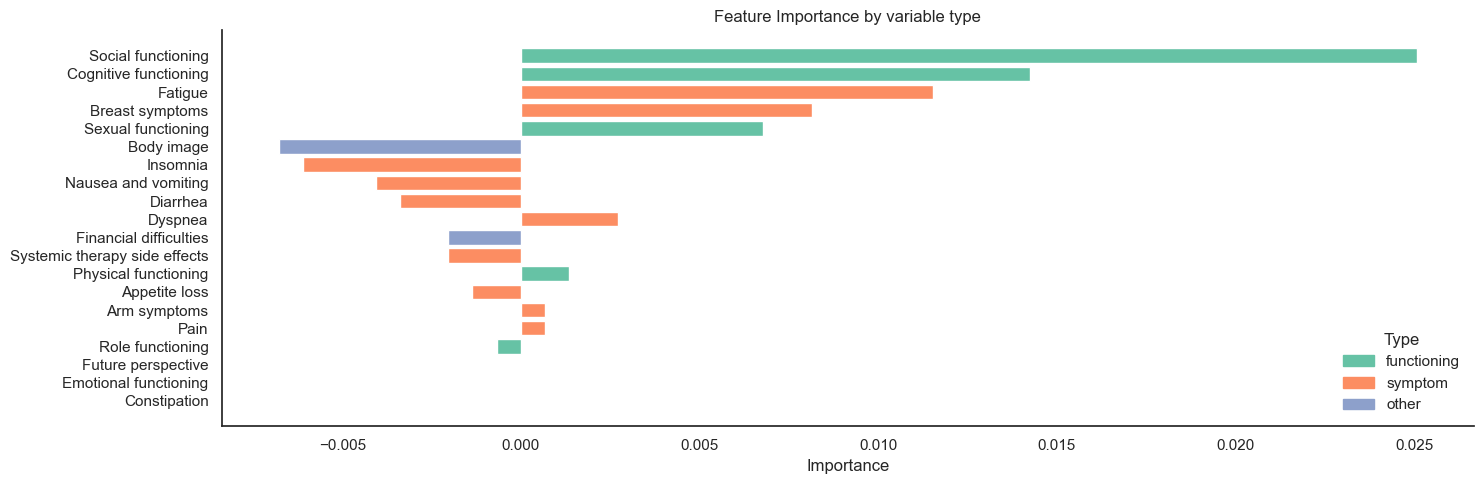

In [7]:
# Calculamos e integramos la importancia por permutación en test para evaluar el impacto real de cada variable sobre el modelo
model_permutation_importance = permutation_importance(model, X_test, y_test, random_state=73)
model_sorted_permutations = sorted(
    zip(X_test.columns, model_permutation_importance.importances_mean),
    key=lambda x: abs(x[1])
)
afn.viz_feature_importance(model_sorted_permutations)

La gráfica presenta la importancia de las variables por permutación, desglosada por tipo clínico. A diferencia del análisis de importancia nativa, aquí el modelo revela una mayor sensibilidad a la alteración de variables funcionales específicas como Social functioning y Cognitive functioning, que aparecen como las más influyentes al provocar una mayor caída en el rendimiento cuando se desordenan. Su efecto se mantiene positivo, lo que confirma su papel relevante en la predicción del modelo.

También destacan algunas variables sintomáticas como Fatigue y Breast symptoms, aunque en menor medida. En este análisis, el modelo parece otorgar menos relevancia a variables que en el análisis nativo ocupaban posiciones altas, como Emotional functioning, que aquí aparece con importancia prácticamente nula, e incluso valores negativos. Esto sugiere que el modelo puede estar capturando relaciones espurias o dependencias débiles con esta variable.

Asimismo, el hecho de que algunas variables presenten valores negativos de importancia (como Constipation, Emotional functioning o Future perspective) indica que su permutación mejora ligeramente el rendimiento del modelo, lo que sugiere una posible contribución ruidosa o contradictoria respecto a la variable objetivo.

In [8]:
# Calculamos la importancia por permutación en train y test, y ordenamos las variables según su relevancia en el conjunto de entrenamiento
permutation_train = permutation_importance(model, X_train, y_train, random_state=23)
permutation_test = permutation_importance(model, X_test, y_test, random_state=23)
sorted_index = permutation_train.importances_mean.argsort()
sorted_features = X_train.columns[sorted_index]
train_importances = pd.DataFrame(permutation_train.importances[sorted_index].T, columns=sorted_features)
test_importances = pd.DataFrame(permutation_test.importances[sorted_index].T, columns=sorted_features)

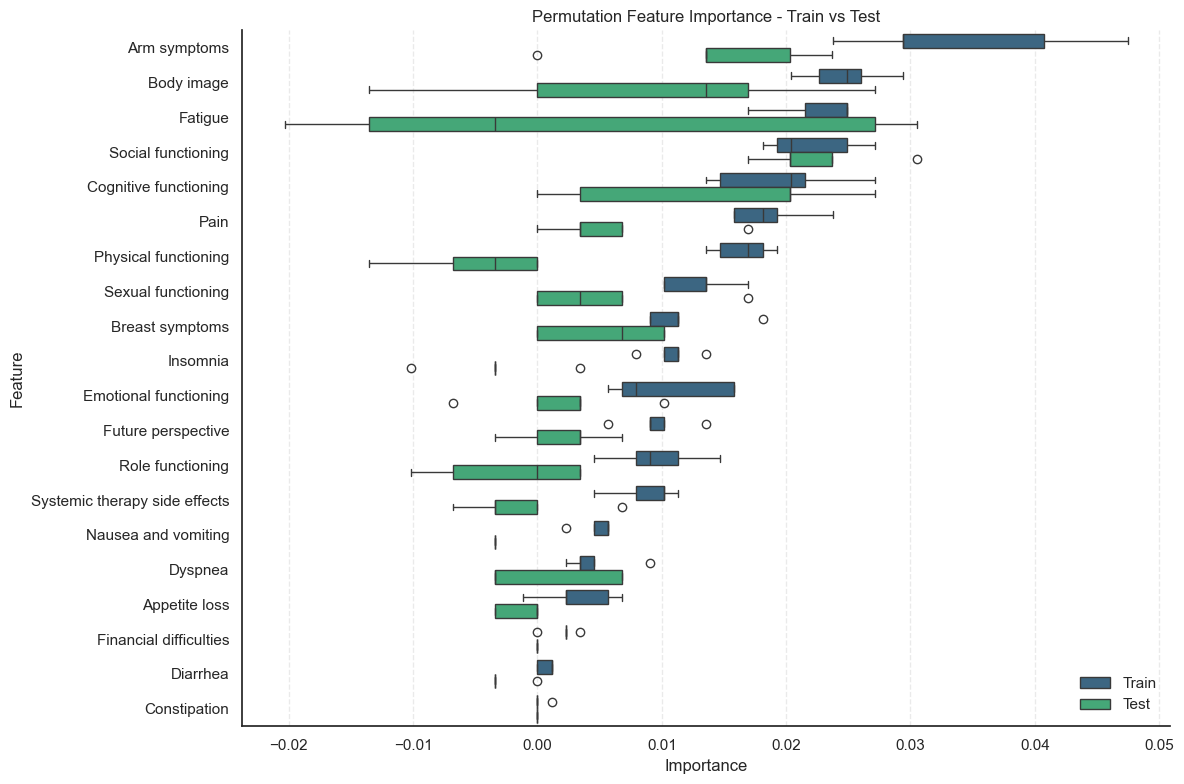

In [10]:
# Visualizamos la comparación de las importancias calculadas
all_cols = train_importances.mean().abs().sort_values(ascending=False).index
train_long = train_importances[all_cols].melt(var_name='Feature', value_name='Importance')
train_long['Set'] = 'Train'
test_long = test_importances[all_cols].melt(var_name='Feature', value_name='Importance')
test_long['Set'] = 'Test'
combined = pd.concat([train_long, test_long], ignore_index=True)

plt.figure(figsize=(12, len(all_cols) * 0.4))  # Altura dinámica
sns.boxplot(data=combined, x='Importance', y='Feature', hue='Set', palette='viridis')
plt.title('Permutation Feature Importance - Train vs Test')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(loc='lower right')
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
sns.despine()
plt.show()

La visualización compara la importancia por permutación de cada variable entre los conjuntos de entrenamiento y prueba. Algunas variables como Arm symptoms muestran una contribución alta y estable en ambos conjuntos, indicando una influencia robusta y generalizable sobre la predicción.

En cambio, variables como Fatigue y Body image, aunque se encuentran entre las más relevantes, presentan una dispersión considerable, especialmente en el conjunto de prueba. Esta variabilidad sugiere que su contribución al modelo no es constante y puede depender de las observaciones concretas, lo que limita su fiabilidad como factor explicativo.

Otras variables, como Constipation, Diarrhea o Financial difficulties, muestran valores cercanos a cero o incluso negativos, lo que sugiere una baja relevancia o posible efecto ruidoso en la predicción. Es el caso también de las variables de tipo funcional como el rol y el aspecto físico.

En conjunto, esta comparación permite identificar qué características son más estables y confiables desde el punto de vista explicativo, y cuáles deben interpretarse con mayor cautela debido a su sensibilidad a los datos evaluados.

## 2. Dependencia Parcial

Los gráficos de dependencia parcial (PDP) permiten visualizar el efecto promedio que tiene una variable sobre la predicción del modelo, manteniendo constantes las demás características. Estos gráficos son especialmente útiles para interpretar modelos no lineales como Random Forest, ya que muestran si el impacto de una variable es creciente, decreciente, constante o presenta umbrales de cambio relevantes.

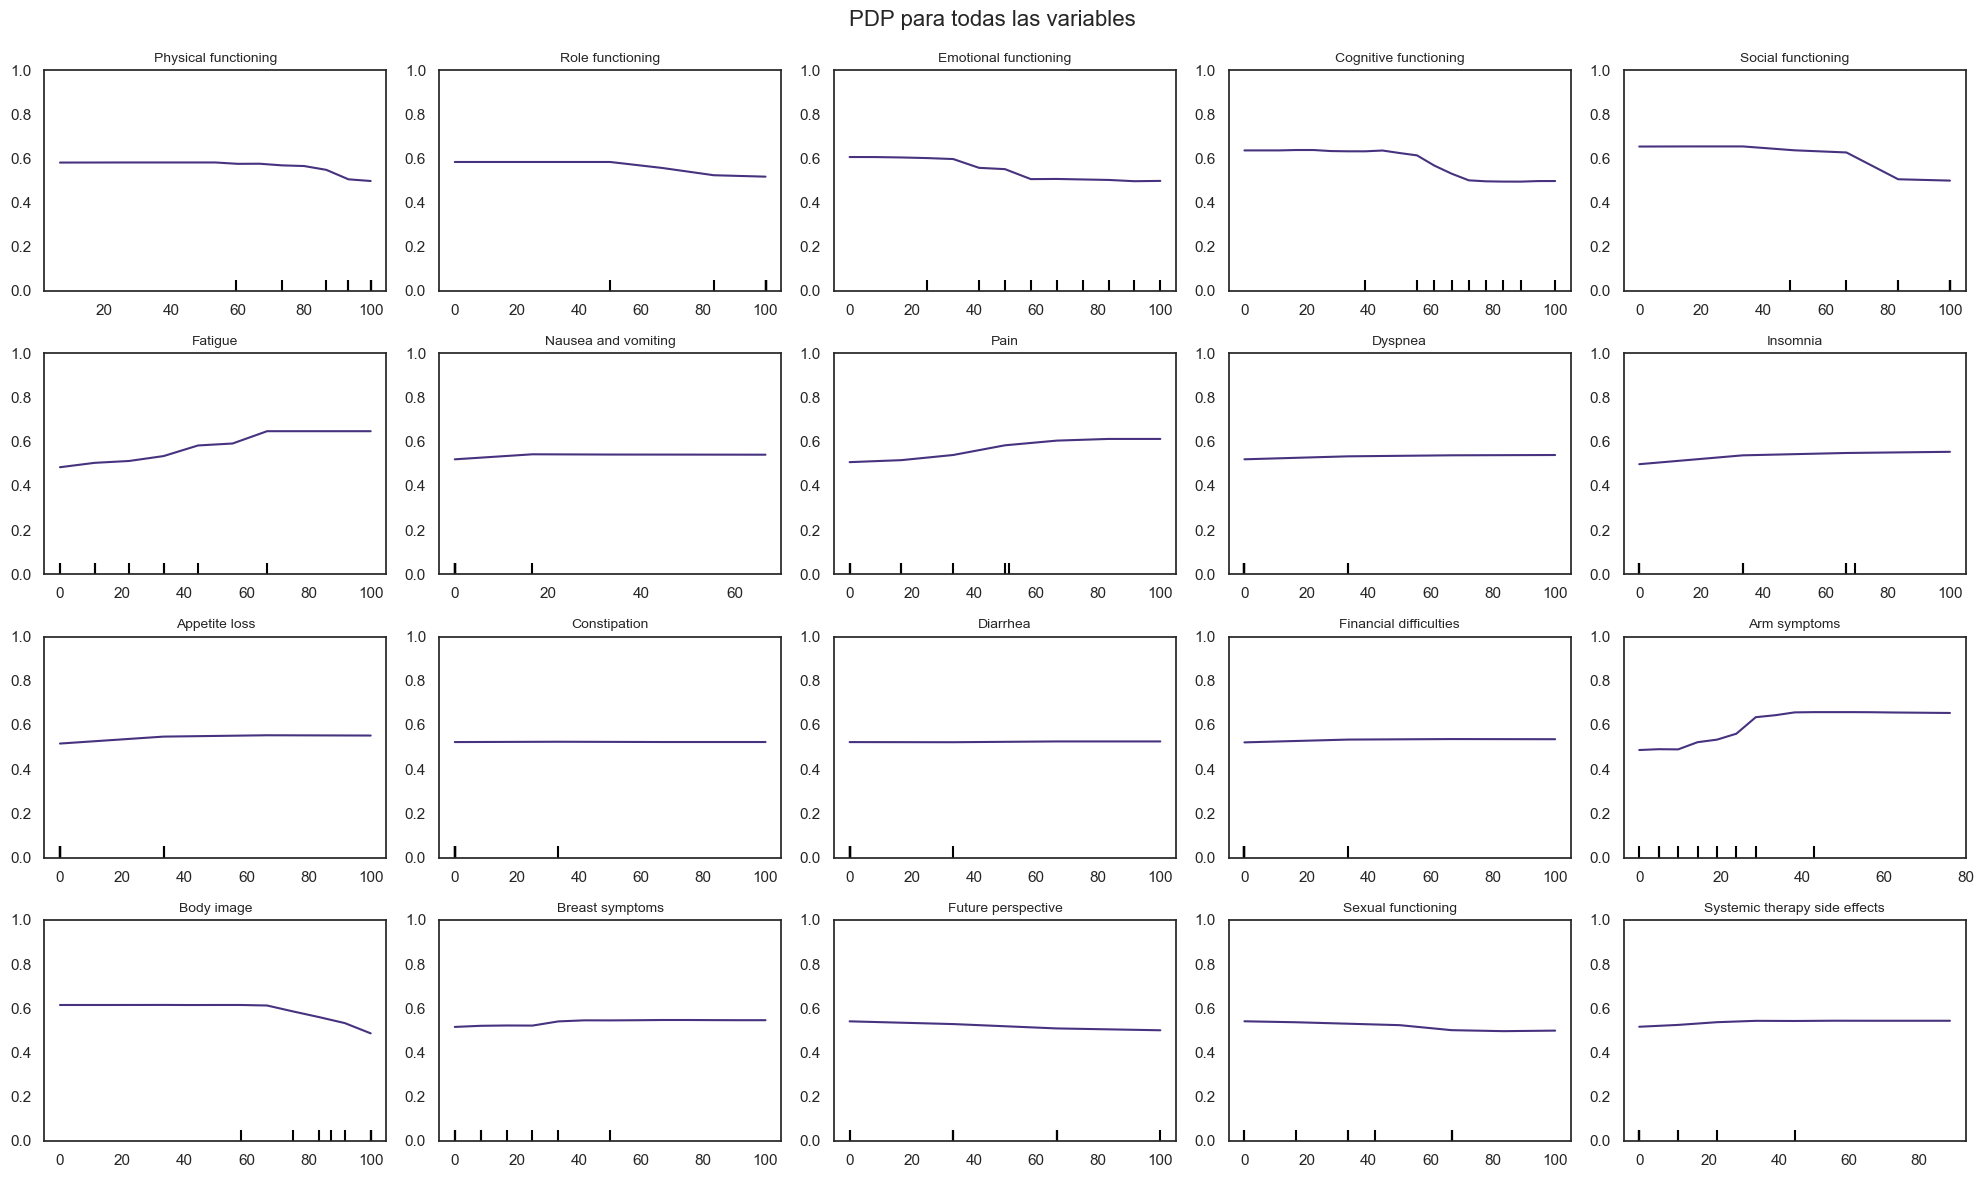

In [12]:
afn.viz_pdp_single(model, X_test)

La representación PDP permite observar el efecto promedio de cada variable sobre la probabilidad predicha de la clase “Mejorable”. Se identifican varios patrones clínicamente coherentes:

- Variables de funcionamiento como Cognitive functioning, Emotional functioning, Social functioning y Physical functioning muestran una relación inversamente proporcional: a mayor puntuación (mejor funcionamiento), menor probabilidad de clasificación como calidad de vida mejorable.

- En contraste, Fatigue, Pain y Arm symptoms presentan curvas crecientes, donde valores altos (más síntomas) incrementan la probabilidad de que el modelo prediga una calidad de vida baja.

- Otras variables como Constipation, Diarrhea o Nausea and vomiting presentan líneas prácticamente planas, lo que indica poca o nula influencia marginal en la predicción del modelo.

Este conjunto de curvas confirma que el modelo ha aprendido relaciones alineadas con el sentido clínico esperado y reafirma el análisis exploratorio: penaliza disfunciones o síntomas intensos, y valora positivamente un buen estado funcional general.

Vamos a visualizar variables en pares para detectar interacciones o efectos combinados que no son evidentes en los PDP individuales. Exploraremos 4 relaciones que pueden ser relevantes para el caso de estudio.

- Cognitive functioning y Emotional functioning,
- Fatigue y Physical functioning,
- Arm symptoms y Body image,
- Role functioning y Social functioning

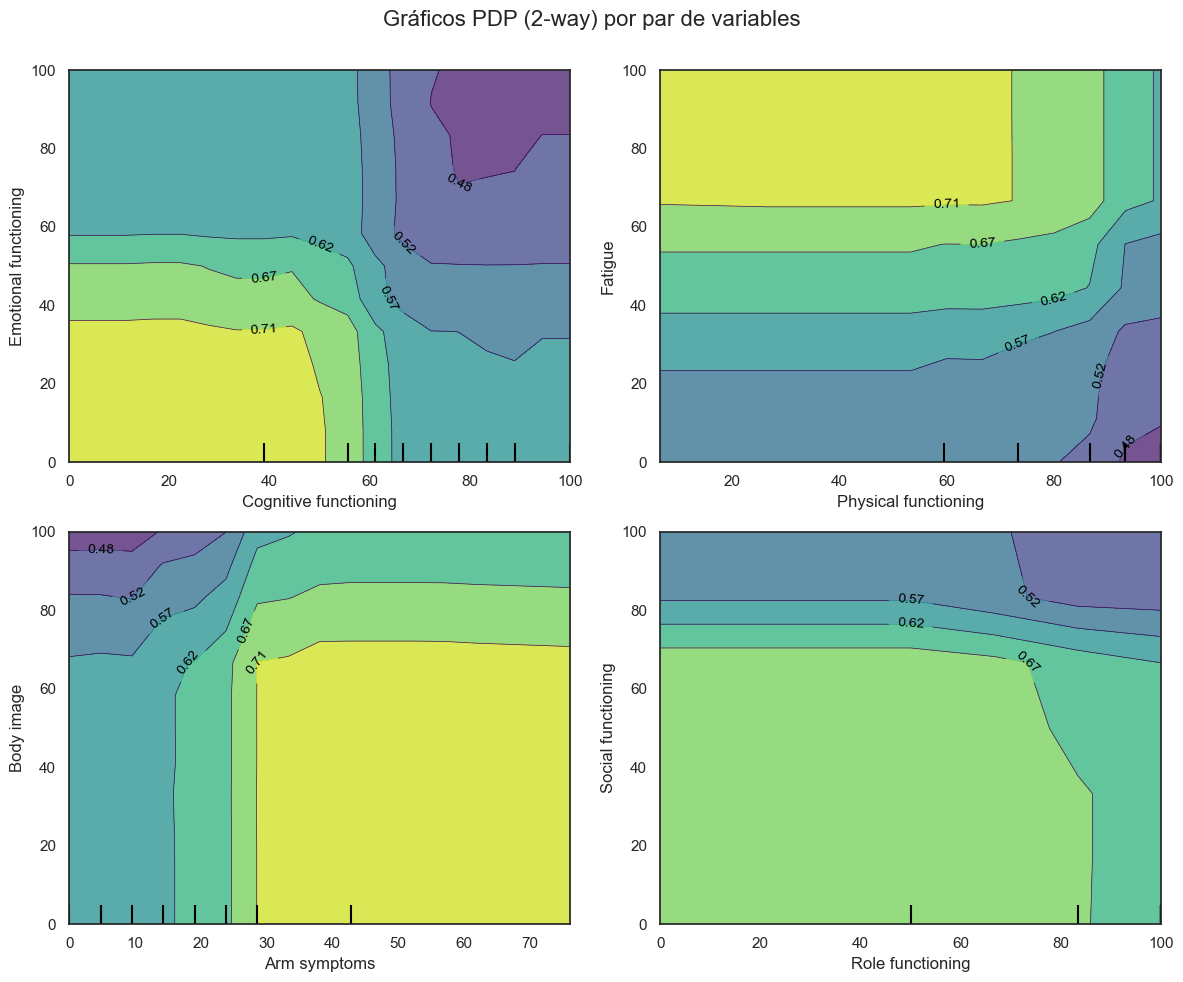

In [15]:
afn.viz_pdp_pairs(model, X_test, [
    ('Cognitive functioning', 'Emotional functioning'),
    ('Physical functioning', 'Fatigue'),
    ('Arm symptoms', 'Body image'),
    ('Role functioning', 'Social functioning'),
])

***Cognitive functioning y Emotional functioning:***

El gráfico refleja que la probabilidad de predicción positiva (mejorable) disminuye notablemente cuando ambos niveles de funcionamiento —cognitivo y emocional— son altos. En el cuadrante superior derecho (valores altos en ambas variables), la probabilidad cae por debajo de 0.5, indicando buena calidad de vida según el modelo.

En cambio, en la zona inferior izquierda (valores bajos de ambas variables), la probabilidad supera el 0.7, lo que sugiere que la combinación de deterioro cognitivo y emocional incrementa claramente el riesgo percibido. La transición más abrupta se observa alrededor del valor 60 en Cognitive functioning, donde el modelo pasa rápidamente de una alta a una baja probabilidad predicha, incluso manteniendo estable Emotional functioning.

Esta interacción sugiere que el modelo penaliza especialmente los déficits simultáneos en ambos dominios, lo cual es coherente.

***Fatigue y Physical functioning:***

Se observa un patrón claro: a medida que aumenta la fatiga y disminuye el funcionamiento físico, la probabilidad predicha de calidad de vida mejorable aumenta progresivamente, superando el umbral de 0.7 cuando ambos factores están comprometidos. En contraste, cuando el funcionamiento físico es alto (por encima de 80) y la fatiga es baja, la probabilidad cae por debajo de 0.5, indicando una predicción más favorable.

El modelo parece responder de forma aditiva y coherente clínicamente, penalizando ambas dimensiones por separado, pero amplificando el efecto cuando coexisten. Este comportamiento refuerza la validez del modelo, ya que refleja la experiencia lógica habitual: las personas con baja capacidad física y niveles elevados de fatiga suelen experimentar un mayor impacto en su calidad de vida.

***Arm symptoms y Body image:***

El modelo muestra un cambio brusco en la probabilidad predicha cuando los síntomas en el brazo superan un umbral de aproximadamente 30. A partir de ese punto, especialmente en combinación con una valoración baja de la imagen corporal (Body image < 70), la probabilidad de predicción positiva se incrementa significativamente, alcanzando valores por encima de 0.7.

Esto sugiere una interacción clara entre afectación física y percepción corporal, donde el impacto en la calidad de vida se amplifica si ambos factores están comprometidos. En contraste, cuando los síntomas físicos son bajos (< 20) y la imagen corporal es alta (> 80), el modelo tiende a predecir con mayor confianza una calidad de vida aceptable (probabilidad < 0.5).

***Role functioning y Social functioning:***

La probabilidad predicha de calidad de vida mejorable es más alta cuando los niveles de Social functioning son bajos, especialmente por debajo de 70, independientemente del valor de Role functioning. Sin embargo, cuando ambas variables presentan valores altos (zona superior derecha), la probabilidad disminuye progresivamente hasta caer por debajo de 0.5.

El modelo penaliza con mayor intensidad la afectación social, y amplifica este efecto si además hay limitaciones en el rol funcional. El cambio más pronunciado ocurre en Social functioning alrededor de 70–80, lo que sugiere un umbral crítico a partir del cual la predicción mejora notablemente.

## 3. Expectación Condicional Individual

Los gráficos ICE (Individual Conditional Expectation) permiten analizar el efecto que tiene una variable sobre la predicción del modelo para cada observación individual. A diferencia de los gráficos PDP, que muestran un efecto promedio, los ICE muestran cómo cambia la predicción para cada caso concreto cuando se modifica una variable manteniendo el resto constante.

Esta técnica es especialmente útil para detectar heterogeneidad en el comportamiento del modelo. Por ejemplo, una variable puede tener un efecto positivo en promedio, pero producir reacciones opuestas en diferentes subgrupos. Los ICE permiten visualizar estas desviaciones, identificar outliers explicativos y validar si el modelo se comporta de forma coherente con distintos perfiles clínicos.

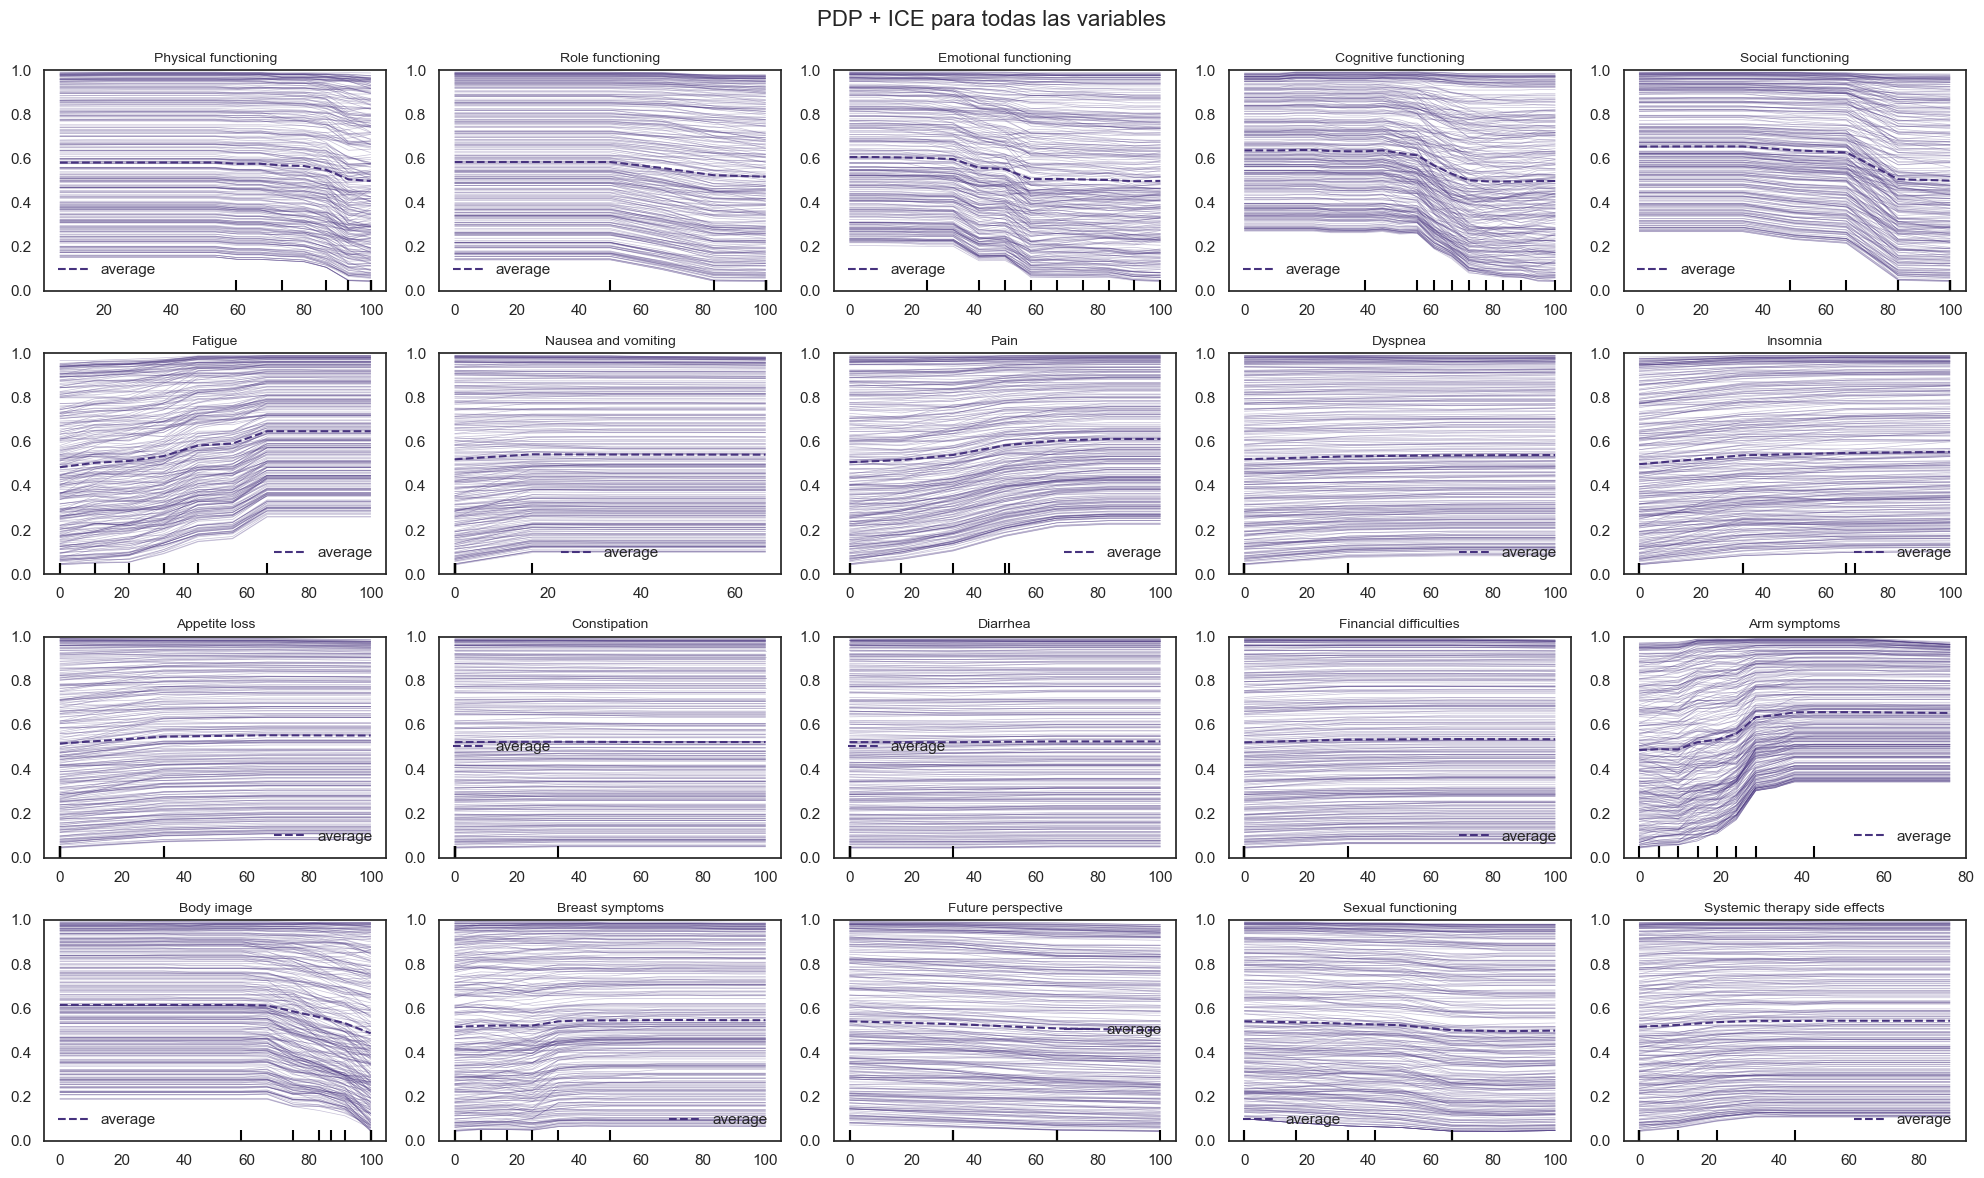

In [16]:
afn.viz_pdp_single(model, X_test, kind='both')

La gran mayoría de las líneas individuales siguen trayectorias muy parecidas entre sí, y no se observan grandes divergencias verticales (es decir, no hay dispersión significativa entre individuos). Las curvas tienden a estar agrupadas y alineadas con la línea media (PDP), lo que indica que el modelo trata todas las observaciones de manera similar ante variaciones en cada característica.

Esto sugiere que el modelo es consistente y predecible para la mayoría de los casos, ha aprendido relaciones estables y generalizables, y que no hay un comportamiento errático ni dependiente de outliers.

## 4. LIME: Explicaciones localmente interpretables independientes del modelo

A continuación se utiliza LIME (Local Interpretable Model-agnostic Explanations) para interpretar de forma local el comportamiento del modelo sobre casos individuales. LIME genera un modelo lineal interpretable en torno a una predicción concreta, aproximando el comportamiento del clasificador en ese entorno local.

El objetivo es comprender qué variables influyen más en cada predicción específica, permitiendo detectar si el modelo basa su decisión en factores clínicamente razonables. Esta técnica es especialmente útil en contextos médicos, donde no solo importa el resultado, sino también justificarlo ante profesionales sanitarios o pacientes.

A lo largo del análisis se examinan diferentes tipos de observaciones: verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos. Esta selección permite contrastar el razonamiento del modelo en situaciones favorables y en errores, ayudando a identificar posibles patrones o sesgos en el proceso de decisión.


In [18]:
# Seleccionamos una observación al azar y visualizamos la predicción con y sin umbral ajustado
lime_idx = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, lime_idx)

Physical functioning  Role functioning  Emotional functioning  \
98                100.00            100.00                  83.33   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
98                  88.89              100.00    22.22                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
98 16.67     0.00     33.33           0.00          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
98                    0.00          4.76      100.00            66.67   

    Future perspective  Sexual functioning  Systemic therapy side effects  
98               33.33               16.67                           0.00

Probabilidad de las clases de QoL: [Aceptable: 0.65, Mejorable: 0.35]
QoL predicha ajustada con umbral 0.43: 0.0
QoL real: 0.0


In [21]:
# Se inicializa el explicador de LIME para datos tabulares, indicando que se trata de un problema de clasificación.
# Se pasan los datos de entrenamiento, los nombres de las características y las etiquetas de clase.
l_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode='classification',
    feature_names=X_train.columns,
    class_names=['Aceptable=0','Mejorable=1'],
    random_state=73
)
# Se genera una explicación local para la observación obtenida al azar, utilizando la probabilidad de predicción del modelo como función de evaluación.
explanation = l_explainer.explain_instance(
    X_test.iloc[lime_idx].values,
    model.predict_proba)
explanation.show_in_notebook()

La explicación generada por LIME para esta observación revela que la predicción del modelo está fuertemente respaldada por un perfil clínico positivo. Características como Social functioning, Body image, Physical functioning y Cognitive functioning presentan valores elevados y contribuyen claramente a la clase Aceptable. La única variable con leve impacto hacia la clase Mejorable es Insomnia, aunque su efecto es muy reducido. Esta visualización refuerza que el modelo toma decisiones alineadas con criterios clínicos esperables y no se basa en patrones espurios o contradictorios.

In [22]:
# Obtenemos una observación erróneamente clasificada como falso negativo
y_pred_thres = model_thresholded.predict(X_test)
fn_index = afn.show_random_false_prediction(model, y_pred_thres, threshold, X_test, y_test)

Physical functioning  Role functioning  Emotional functioning  \
220                 93.33            100.00                  66.67   

     Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
220                  66.67              100.00     0.00                 0.00   

     Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
220 33.33    33.33      0.00           0.00          0.00     33.33   

     Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
220                    0.00         14.29       91.67             0.00   

     Future perspective  Sexual functioning  Systemic therapy side effects  
220               33.33                0.00                          22.22

Predicción sin ajustar: [0.65 0.35]
Predicción ajustada con umbral (0.426): 0 (0.35)
QoL real: 1.0
Índice: 220


La observación tiene una calidad de vida real clasificada como mejorable (1.0), pero el modelo lo ha predicho como aceptable (0.0) incluso tras aplicar el umbral ajustado (0.426). La probabilidad asignada a la clase positiva es baja (0.35), lo que indica que el modelo no percibió señales suficientes en este caso para cambiar su predicción. Este tipo de análisis es clave para identificar limitaciones en la sensibilidad del modelo y reflexionar sobre posibles mejoras.

In [24]:
explanation = l_explainer.explain_instance(
    X_test.iloc[fn_index].values,
    model.predict_proba)
explanation.show_in_notebook()

El modelo predice calidad de vida aceptable (0) con una probabilidad del 65%, pero la clase real es mejorable (1). A pesar de aplicar el umbral ajustado (0.426), el modelo no supera el corte y mantiene su decisión incorrecta. El análisis de LIME revela que la predicción se sustenta en valores altos en dimensiones funcionales clave (Social, Role, Physical, Cognitive), mientras que variables que podrían indicar deterioro, como Fatigue o Insomnia, están en niveles mínimos. Esto sugiere que el modelo prioriza marcadores positivos fuertes y podría estar infraestimando señales clínicas sutiles. Este tipo de error es crítico en contextos clínicos, donde no detectar un caso mejorable podría implicar pérdida de oportunidad terapéutica.

In [25]:
# Obtenemos una observación con error de tipo I (falso positivo)
fp_index = afn.show_random_false_prediction(model, y_pred_thres, threshold, X_test, y_test, negative=False)

Physical functioning  Role functioning  Emotional functioning  \
75                 93.33            100.00                  41.67   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
75                  61.11              100.00     0.00                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
75  0.00     0.00     33.33           0.00          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
75                    0.00          4.76       83.33            16.67   

    Future perspective  Sexual functioning  Systemic therapy side effects  
75                0.00                0.00                           0.00

Predicción sin ajustar: [0.48 0.52]
Predicción ajustada con umbral (0.426): 1 (0.52)
QoL real: 0.0
Índice: 75


Este ejemplo a una observación con una calidad de vida real aceptable (0.0), pero el modelo la predice como mejorable (1.0) con una probabilidad del 52%, justo por encima del umbral ajustado (0.426).

In [27]:
explanation = l_explainer.explain_instance(
    X_test.iloc[fp_index].values,
    model.predict_proba)
explanation.show_in_notebook()

El modelo ha predicho calidad de vida mejorable (1) con una probabilidad del 52%, aunque el valor real era aceptable (0). LIME permite identificar que esta predicción se ha visto influida por niveles intermedios en variables como Emotional functioning (41.67) y Body image (83.33), que han sido interpretados como señales de deterioro. A pesar de que la mayoría de las variables funcionales presentan valores óptimos, la combinación concreta parece haber inducido al modelo a una clasificación errónea. Este tipo de explicación ayuda a detectar sesgos o sensibilidades excesivas ante ciertas configuraciones clínicas.

## 5. DiCE: Explicaciones contrafactuales diversas

Para complementar las explicaciones locales, se utiliza DiCE (Diverse Counterfactual Explanations) como herramienta para generar contraejemplos: instancias sintéticas mínimamente modificadas que cambiarían la predicción del modelo. El objetivo de esta técnica es identificar qué variables deberían variar —y en qué dirección— para que un caso cambie de clase, proporcionando así una interpretación directa y accionable.

En el contexto clínico, DiCE permite entender qué mejoras específicas en los atributos de un paciente podrían aumentar la probabilidad de recibir una predicción favorable. Además, revela posibles dependencias implícitas del modelo respecto a ciertas variables o combinaciones. Esta estrategia resulta especialmente útil en el análisis de observaciones clasificadas erróneamente, ya que permite examinar qué ajustes serían necesarios para obtener una predicción correcta, facilitando una reflexión crítica sobre la robustez del modelo y sus implicaciones prácticas.

In [28]:
# Preparamos el conjunto para utilizarlo con DiCE
train_df = X_train.copy()
train_df['QoL'] = y_train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Physical functioning           884 non-null    float64
 1   Role functioning               884 non-null    float64
 2   Emotional functioning          884 non-null    float64
 3   Cognitive functioning          884 non-null    float64
 4   Social functioning             884 non-null    float64
 5   Fatigue                        884 non-null    float64
 6   Nausea and vomiting            884 non-null    float64
 7   Pain                           884 non-null    float64
 8   Dyspnea                        884 non-null    float64
 9   Insomnia                       884 non-null    float64
 10  Appetite loss                  884 non-null    float64
 11  Constipation                   884 non-null    float64
 12  Diarrhea                       884 non-null    flo

In [29]:
# Configuración de los objetos Data y Model para generar contraejemplos con DiCE
dice_data = dice.Data(
    dataframe=train_df, 
    outcome_name='QoL',
    continuous_features=[],
)
dice_model = dice.Model(model=model, model_type='classifier', backend="sklearn")

In [30]:
# Obtenemos una observación al azar
dice_index = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, dice_index)

Physical functioning  Role functioning  Emotional functioning  \
267                 93.33            100.00                  91.67   

     Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
267                  94.44              100.00     0.00                 0.00   

     Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
267 16.67    33.33      0.00           0.00          0.00     33.33   

     Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
267                    0.00          9.52      100.00             0.00   

     Future perspective  Sexual functioning  Systemic therapy side effects  
267               66.67               50.00                           0.00

Probabilidad de las clases de QoL: [Aceptable: 0.85, Mejorable: 0.15]
QoL predicha ajustada con umbral 0.43: 0.0
QoL real: 1.0


In [31]:
dice_explainer = dice.Dice(dice_data, dice_model, method='random')
dice_cfactuals = dice_explainer.generate_counterfactuals(
    X_test.iloc[[70]], # caso 70
    total_CFs=5,
    desired_class="opposite",
    features_to_vary=['Fatigue', 'Pain', 'Cognitive functioning'],
    verbose=True
)  

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec


In [32]:
dice_cfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0.0)


Physical functioning  Role functioning  Emotional functioning  \
0                 93.33            100.00                  75.00   

   Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
0                  83.33              100.00    44.44                 0.00   

   Pain  Dyspnea  Insomnia  ...  Constipation  Diarrhea  \
0 50.00    33.33     33.33  ...          0.00      0.00   

   Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
0                    0.00         14.29       83.33             0.00   

   Future perspective  Sexual functioning  Systemic therapy side effects  QoL  
0               33.33               66.67                          44.44 0.00  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 1.0)


Physical functioning Role functioning Emotional functioning  \
0                    -                -                     -   
1                    -                -                     -   
2                    -                -                     -   
3                    -                -                     -   
4                    -                -                     -   

  Cognitive functioning Social functioning            Fatigue  \
0    33.333333333333336                  -  77.77777777777779   
1     55.55555555555556                  -                  -   
2                     -                  -  88.88888888888889   
3                     -                  -                  -   
4                  50.0                  -                  -   

  Nausea and vomiting   Pain Dyspnea Insomnia  ... Constipation Diarrhea  \
0                   -      -       -        -  ...            -        -   
1                   -      -       -        -  ...            -        -   
2                   -      -       -        -  ...            -        -   
3                   -  100.0       -        -  ...            -        -   
4                   -      -       -        -  ...            -        -   

  Financial difficulties Arm symptoms Body image Breast symptoms  \
0                      -            -          -               -   
1                      -            -          -               -   
2                      -            -          -               -   
3                      -            -          -               -   
4                      -            -          -               -   

  Future perspective Sexual functioning Systemic therapy side effects  QoL  
0                  -                  -                             -  1.0  
1                  -                  -                             -  1.0  
2                  -                  -                             -  1.0  
3                  -                  -                             -  1.0  
4                  -                  -                             -  1.0  

[5 rows x 21 columns]

## 6. SHAP

In [ ]:
shap.initjs()
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
n_features = len(X_test.columns)
cols = 3
rows = (len(X_test.columns) + cols - 1)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(X_test.columns):
    shap.dependence_plot(feature, shap_values, X_test, ax=axes[i], show=False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
shap_index = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, shap_index)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[shap_index], max_display=20)

In [ ]:
shap.plots.waterfall(shap_values[fn_index], max_display=20)

In [ ]:
shap.plots.waterfall(shap_values[fp_index], max_display=20)